In [1]:
%load_ext autoreload
%autoreload 2
import config
import torch
from app.Classifiers.Classifier_NN import Classifier_IMGNET, Classifier_MNIST
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from app.NObSP.NObSP_Decomposition import NObSP_NN_single_MultiOutput, NObSP_NN_single_MultiOutput_reg
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader as tf_dataloader
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import os
from tqdm.notebook import tqdm
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(2, 2))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [4]:
# Cargar los tensores guardados
images = torch.load('images.pth')
X = torch.load('tensors.pth')
X = torch.stack(X)  # Convierte 'X' en un tensor si es una lista de listas
y = torch.load('labels.pth')

y = torch.tensor(y)  # Convierte 'y' en un tensor si es una lista de enteros


# Suponiendo que 'tensor_labels' es tu tensor de etiquetas
tensor_labels = y

# Paso 1: Extraer las etiquetas únicas y crear el mapeo
unique_labels = torch.unique(tensor_labels).tolist()
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Paso 2: Convertir etiquetas a índices mapeados
mapped_indices = torch.tensor([label_to_index[label.item()] for label in tensor_labels])

# Paso 3: Aplicar one-hot encoding
y = torch.nn.functional.one_hot(mapped_indices, num_classes=len(unique_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


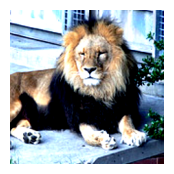

In [5]:
imshow(torchvision.utils.make_grid(images[0]))

In [6]:
X_sample = []
y_sample = []
index_used = []

sample_size = 200
# Supongamos que 'num_classes' es el número de clases en tus etiquetas
for i in range(10):
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    index_used.append(indices)
    X_sample.append(X[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

index_used = [tensor.item() for sublist in index_used for tensor in sublist]
images_sample = [images[i] for i in index_used]
X_sample = torch.cat(X_sample)
y_sample = torch.cat(y_sample)

In [7]:
X_sample.shape

torch.Size([2000, 25088])

In [8]:
N = np.size(X_sample, 0); # Defining the number of datapoints
in_feat = np.size(X_sample, 1)

In [9]:
t = np.arange(0, N)
train_split = int(0.9 * N)
p = 10

In [10]:
epochs = 300
learning_rate = 0.0001

In [11]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    train_size = train_split,
    random_state=42
) 

## Creating model for single nonlinear effects

classifier = Classifier_MNIST(in_number=X_sample.shape[1], out_number=y_sample.shape[1]) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

# Training loop for the model 1

In [12]:
for epoch in range(epochs):
    classifier.train() # Setting the model in training mode
    y_prob, x_p, y_lin = classifier(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    classifier.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = classifier(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.30278 | test Loss: 2.29102
Epoch: 10 | Loss: 1.65332 | test Loss: 1.64713
Epoch: 20 | Loss: 1.49108 | test Loss: 1.55273
Epoch: 30 | Loss: 1.47131 | test Loss: 1.55174
Epoch: 40 | Loss: 1.46816 | test Loss: 1.54966
Epoch: 50 | Loss: 1.46742 | test Loss: 1.55689
Epoch: 60 | Loss: 1.46730 | test Loss: 1.55323
Epoch: 70 | Loss: 1.46682 | test Loss: 1.55987
Epoch: 80 | Loss: 1.46673 | test Loss: 1.55207
Epoch: 90 | Loss: 1.46671 | test Loss: 1.55141
Epoch: 100 | Loss: 1.46669 | test Loss: 1.55022
Epoch: 110 | Loss: 1.46621 | test Loss: 1.54924
Epoch: 120 | Loss: 1.46614 | test Loss: 1.55294
Epoch: 130 | Loss: 1.46560 | test Loss: 1.55196
Epoch: 140 | Loss: 1.46559 | test Loss: 1.55241
Epoch: 150 | Loss: 1.46557 | test Loss: 1.54949
Epoch: 160 | Loss: 1.46557 | test Loss: 1.55000
Epoch: 170 | Loss: 1.46557 | test Loss: 1.55061
Epoch: 180 | Loss: 1.46556 | test Loss: 1.55027
Epoch: 190 | Loss: 1.46556 | test Loss: 1.54987
Epoch: 200 | Loss: 1.46556 | test Loss: 1.54980
Epo

In [13]:
correct = 0
total = 0

classifier.eval()
with torch.inference_mode():
    outputs, _, _ = classifier(X_test)
    for tensor, label in zip(outputs, y_test):
        predicted = torch.argmax(tensor)
        label = torch.argmax(label) 
        total += 1
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.3f} %')

Test Accuracy: 91.000 %


In [14]:
classifier.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = classifier(
        X_sample
    )  # Computing the nonlinear transformation of the input data X

In [15]:
if os.path.exists("betas_tensor.pth"):
    betas_tensor = torch.load("betas_tensor.pth")
else:
    betas_tensor = NObSP_NN_single_MultiOutput_reg(
        X_sample, y_est_1, classifier
    )  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer
    torch.save(betas_tensor, "betas_tensor.pth")

In [16]:
def get_contrib(X, model, betas):
    X_new = X.clone()
    clase = int(torch.argmax(model(X_new.unsqueeze(0))[0].detach(), axis=1))
    X_target_tot = torch.zeros((1, list(model.children())[-1].in_features))

    X_temp = X_new.repeat(len(X_new), 1)
    X_temp = torch.eye(len(X_new)) * X_temp
    with torch.inference_mode():
        _, X_latent, _ = model(X_new.unsqueeze(0))
        _, X_target, _ = model(X_temp)
    X_target_tot = torch.cat((X_target_tot, X_target), 0)
    X_target_tot = X_target_tot[1:]

    contrib = (X_target_tot @ betas[:, :, clase]).diag()
    return clase, contrib, X_latent

In [17]:
real_labels = (148, 22, 21, 208, 291, 283, 2, 281, 292, 269)
real_labels = sorted(real_labels)
real_labels

[2, 21, 22, 148, 208, 269, 281, 283, 291, 292]

In [18]:
real_labels[5]

269

In [19]:
real_labels = (148, 22, 21, 208, 291, 283, 2, 281, 292, 269)
real_labels = sorted(real_labels)

def train_contribs(X, model, betas):
    contribs = []
    labels = []
    tensors = []
    latents = []
    for i in tqdm(range(len(X))):
        label, contrib, latent = get_contrib(X[i], model, betas)
        contribs.append(contrib.numpy())
        labels.append(real_labels[label])
        tensors.append(X[i].numpy())
        latents.append(latent.numpy()[0])

    train_contribs = pd.DataFrame(
        {
            'Contrib': contribs,
            'Label': labels,
            'Flatten': tensors,
            'Latent': latents
        }
    )
    return train_contribs

In [20]:
if os.path.exists("train_contribs.pkl"):
    train_contribs = pd.read_pickle("train_contribs.pkl")
else: 
    train_contribs = train_contribs(X_sample, classifier, betas_tensor)
    train_contribs.to_pickle("train_contribs.pkl")
    
train_contribs.head()

,Contrib,Label,Flatten,Latent
0,"[0.1431397, 0.90432656, -0.36506814, -0.003365...",2,"[-0.5511036, -0.29204616, 0.10476053, 0.568497...","[28.935493, 0.0, 0.0, 0.0, 65.97811, 13.508507..."
1,"[0.14147462, 0.90553, -0.36324248, -0.00109568...",2,"[-0.35321942, -0.17361829, -0.06846562, -0.350...","[48.392044, 0.0, 0.0, 0.0, 65.76195, 0.8651428..."
2,"[0.14405718, 0.91183984, -0.37118366, 0.001225...",2,"[0.38323995, 0.7307725, 0.5474878, 0.33275586,...","[47.68238, 1.2988791, 0.0, 0.0, 57.648125, 0.0..."
3,"[0.14314975, 0.90798926, -0.36865634, -0.01073...",2,"[-0.5316086, -0.903232, -1.06931, -1.3272408, ...","[72.33623, 0.0, 0.0, 0.0, 94.77475, 0.0, 0.0, ..."
4,"[0.14445321, 0.906966, -0.36711237, 0.00179407...",2,"[-0.7151449, -0.99648225, -0.40863726, 0.30489...","[31.054405, 0.0, 0.0, 0.0, 40.036198, 0.0, 0.0..."


In [21]:
def viz_contrib(train_contribs):
    
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=20,
    )
    tsne_contrib = tsne.fit_transform(train_contribs['Contrib'].apply(pd.Series))
    tsne_contrib = pd.DataFrame(tsne_contrib, columns=['tsne_1', 'tsne_2'])
    
    tsne_flatten = tsne.fit_transform(train_contribs['Flatten'].apply(pd.Series))
    tsne_flatten = pd.DataFrame(tsne_flatten, columns=['tsne_1', 'tsne_2'])
    
    tsne_latent = tsne.fit_transform(train_contribs['Latent'].apply(pd.Series))
    tsne_latent = pd.DataFrame(tsne_latent, columns=['tsne_1', 'tsne_2'])
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))
    sns.scatterplot(
        data=tsne_contrib,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[0]
    )
    ax[0].set_title('Contributions')
    ax[0].grid(alpha=0.4)
    
    sns.scatterplot(
        data=tsne_flatten,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[1]
    )
    ax[1].set_title('Flatten')
    ax[1].grid(alpha=0.4)
    
    sns.scatterplot(
        data=tsne_latent,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[2]
    )
    ax[2].set_title('Latent')
    ax[2].grid(alpha=0.4)
    
    plt.show()

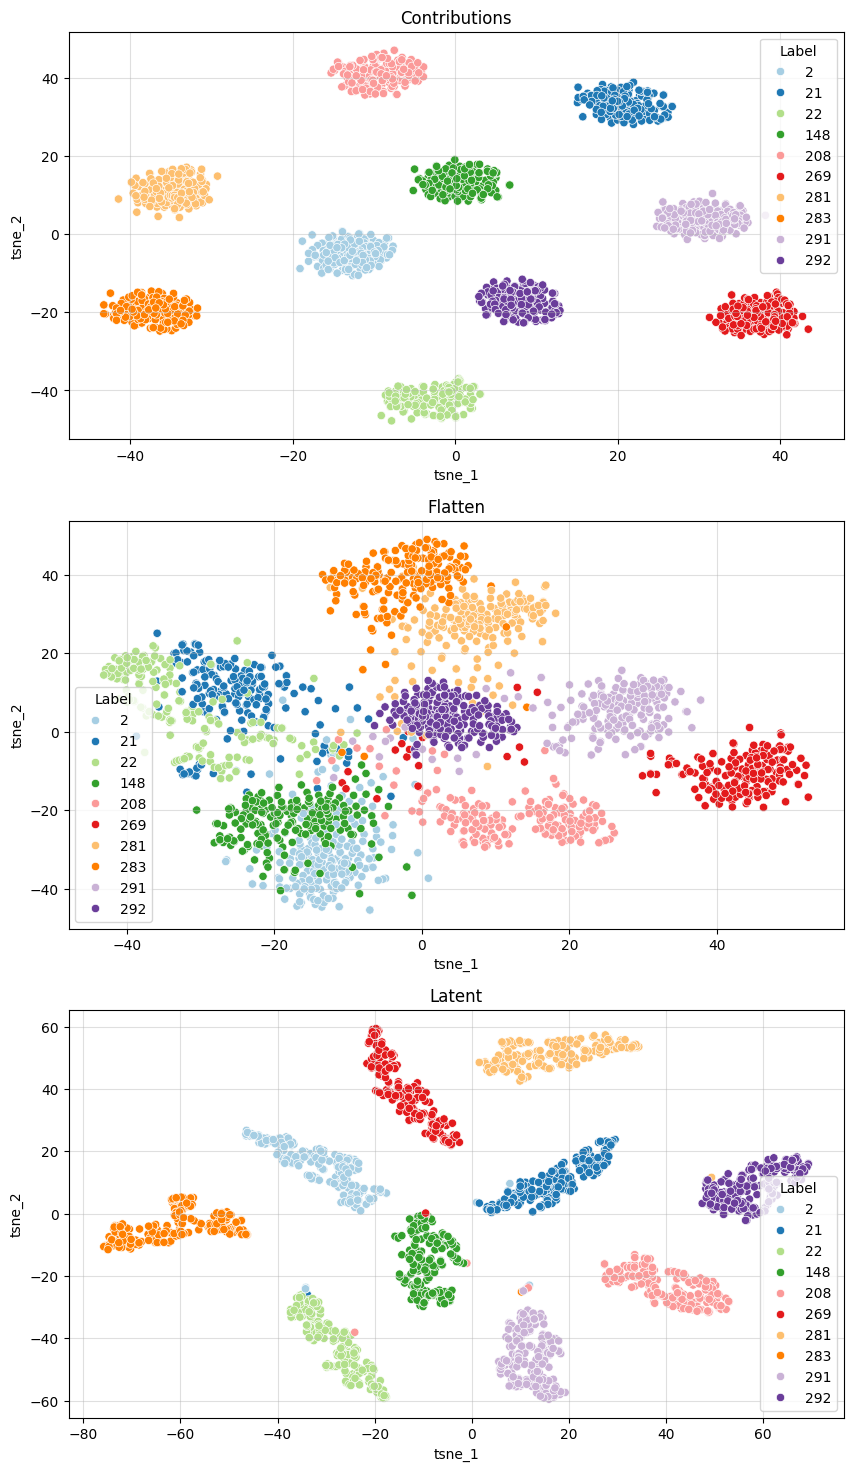

In [22]:
viz_contrib(train_contribs)

In [23]:
train_contribs.columns

Index(['Contrib', 'Label', 'Flatten', 'Latent'], dtype='object')

In [24]:
from torchvision.models import resnet18 as model 
from torchvision.models import ResNet18_Weights as model_weights
# Cargar el modelo preentrenado de DenseNet121
weights = model_weights.IMAGENET1K_V1
model = model(weights=weights)
model.eval()  # Poner el modelo en modo de evaluación


def hook(module, input, output):
    global flatten
    flatten.append(output.clone().detach())
    flatten = [tensor.view(-1) for batch in flatten for tensor in batch]
    
model.layer4[-1].bn2.register_forward_hook(hook)

In [25]:
def top5_cosine(data, y, index, flatten, contrib, latent, net_label, df): #incluir label original, label del modelo
    
    # Convertir cada array en la columna del DataFrame en un tensor
    contrib_list = [torch.tensor(x) for x in df['Contrib']]
    flatten_list = [torch.tensor(x) for x in df['Flatten']]
    latent_list = [torch.tensor(x) for x in df['Latent']]
    

    # Calcular la similitud del coseno para las contribuciones
    similarities_contrib = [F.cosine_similarity(contrib, tensor, dim=0) for tensor in contrib_list]
    similarities_contrib = torch.tensor(similarities_contrib)
    
    # Calcular la similitud del coseno para los flatten
    similarities_flatten = [F.cosine_similarity(flatten, tensor, dim=0) for tensor in flatten_list]
    similarities_flatten = torch.tensor(similarities_flatten)
    
   # Calcular la similitud del coseno para los flatten
    similarities_latent = [F.cosine_similarity(latent, tensor, dim=0) for tensor in latent_list]
    similarities_latent = torch.tensor(similarities_latent) 

    # Encontrar los top 5
    top5_indices_contrib = torch.topk(similarities_contrib, 5).indices
    top5_indices_flatten = torch.topk(similarities_flatten, 5).indices
    top5_indices_latent = torch.topk(similarities_latent, 5).indices

    # Visualizar la imagen original
    fig, axs = plt.subplots(4, 5, figsize=(15, 10))
    img = torchvision.utils.make_grid(data[index]) / 2 + 0.5
    npimg = img.numpy()
    axs[0, 2].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[0, 2].set_title(f"Real Label: {real_labels[torch.argmax(y[index])]}\n Model Label: {net_label}")

    # Desactivar los espacios vacíos en la primera fila
    for i in [0, 1, 3, 4]:
        axs[0, i].axis("off")

    # Visualizar las imágenes más similares para los tensores
    for i, idx in enumerate(top5_indices_contrib):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[1, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[1, i].set_title(f"Contrib {i+1} - Sim: {similarities_contrib[idx]:.3f}\n Real Label: {real_labels[torch.argmax(y_sample[idx])]}")

    # Visualizar las imágenes más similares para los flatten
    for i, idx in enumerate(top5_indices_flatten):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[2, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[2, i].set_title(f"Flatten {i+1} - Sim: {similarities_flatten[idx]:.3f}\n Real Label: {real_labels[torch.argmax(y_sample[idx])]}")

    # Visualizar las imágenes más similares para los flatten
    for i, idx in enumerate(top5_indices_latent):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[3, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[3, i].set_title(f"Latent {i+1} - Sim: {similarities_latent[idx]:.3f}\n Real Label: {real_labels[torch.argmax(y_sample[idx])]}")
    
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:
def procesar_lista(lista, top_n, positivo=True):
    if positivo:
        elementos = [(i, num) for i, num in enumerate(lista) if num > 0]
    else:
        elementos = [(i, num) for i, num in enumerate(lista) if num < 0]
    total_elementos = sum(num for _, num in elementos)
    porcentajes = [(i, num, num / total_elementos * 100) for i, num in elementos]
    porcentajes_ordenados = sorted(porcentajes, key=lambda x: x[2], reverse=positivo)
    return porcentajes_ordenados[:top_n]

def graficar_elementos(ax, resultado, top_n, positivo=True):
    indices = [tupla[0] for tupla in resultado]
    entradas = [tupla[1] for tupla in resultado]
    porcentajes = [tupla[2] for tupla in resultado]

    color = 'tab:blue' if positivo else 'tab:red'
    ax.barh(range(len(indices)), porcentajes, color = color)

    etiquetas_y = [f"Entrada: {i}, Valor: {e:.3f}" for i, e in zip(indices, entradas)]
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(etiquetas_y)

    ax.invert_yaxis()

    ax.set_xlabel('Porcentaje (%)')
    if positivo:
        ax.set_title(f'Top {top_n} Entradas Positivas por Porcentaje')
    else:
        ax.set_title(f'Top {top_n} Entradas Negativas por Porcentaje')

def graficar_entradas(tensor, top_n=15):
    lista = tensor.tolist()
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    resultado_positivos = procesar_lista(lista, top_n, positivo=True)
    graficar_elementos(axs[0], resultado_positivos, top_n, positivo=True)

    resultado_negativos = procesar_lista(lista, top_n, positivo=False)
    graficar_elementos(axs[1], resultado_negativos, top_n, positivo=False)

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


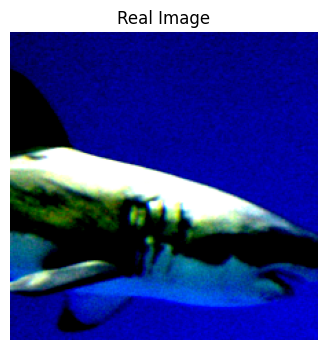

In [341]:
index = 18000
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(images[index].permute(1, 2, 0))
ax.axis('off')
ax.set_title("Real Image")
plt.show()

[tensor([ 0.2653, -0.2733,  0.2045,  ...,  0.3290,  0.7266,  0.8806])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

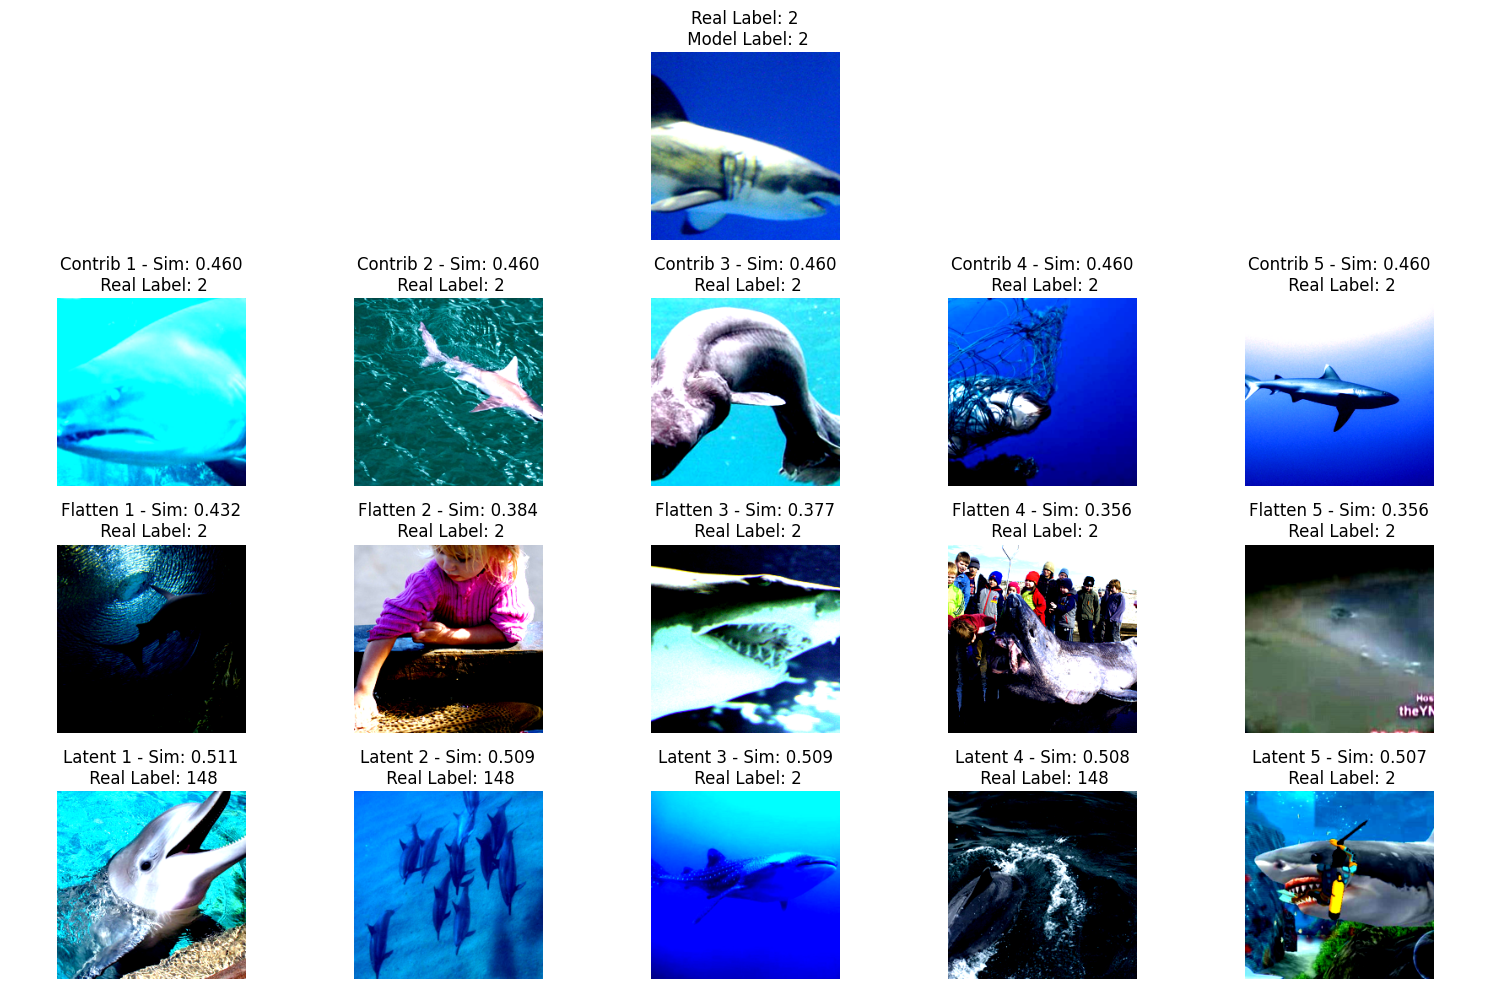

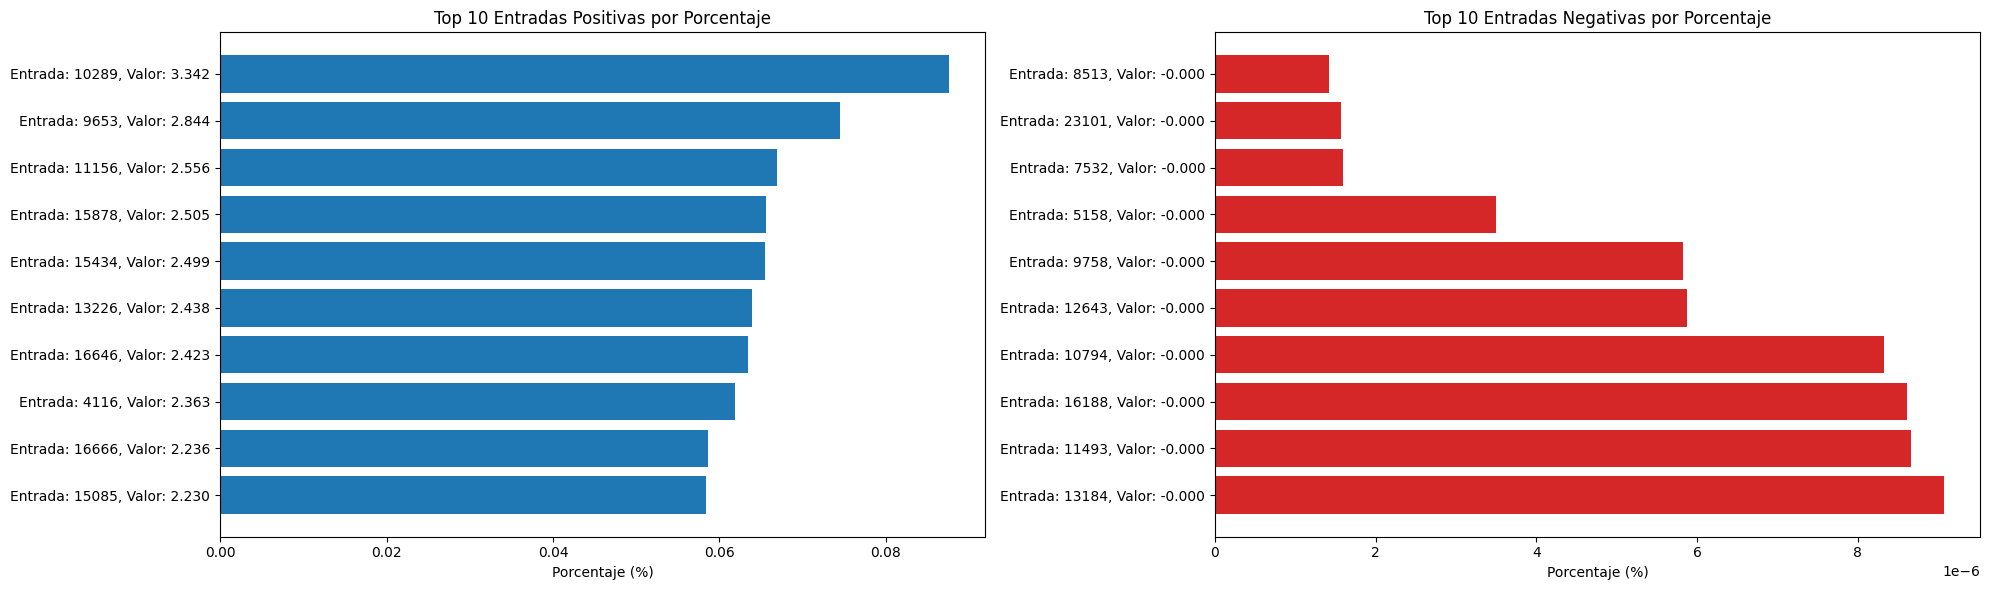

In [342]:
flatten = []
with torch.inference_mode():
    net_label = model(images[index].unsqueeze(0))
    net_label = torch.argmax(net_label)
    _, contrib, latent = get_contrib(flatten[0], classifier, betas_tensor)

print(flatten)
top5_cosine(images, y, index, flatten[0], contrib, latent[0], net_label, train_contribs)
graficar_entradas(contrib, top_n=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


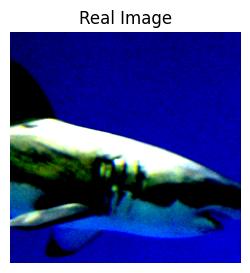

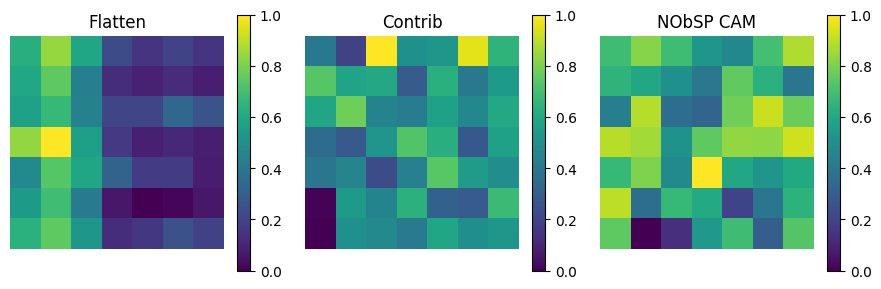

In [343]:
flatten2 = flatten[0].clone()
contrib2 = contrib.clone()
shape = (7, 512, 7)

nobs_cam = flatten2*contrib2
nobs_cam = nobs_cam.view(shape)
nobs_cam = torch.mean(nobs_cam, dim=1)
nobs_cam = (nobs_cam - nobs_cam.min()) / (nobs_cam.max() - nobs_cam.min()) # hacer una prueba con el softmax

contrib2 = contrib2.view(shape)
contrib2 = torch.mean(contrib2, dim=1)
contrib2 = (contrib2 - contrib2.min()) / (contrib2.max() - contrib2.min())

flatten2 = flatten2.view(shape)
flatten2 = torch.mean(flatten2, dim=1)
flatten2 = (flatten2 - flatten2.min()) / (flatten2.max() - flatten2.min())

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(images[index].permute(1, 2, 0))
ax.axis('off')
ax.set_title("Real Image")
plt.show()

cmap = 'viridis'
fig, ax = plt.subplots(1, 3, figsize=(9, 3))  # Aumentamos el ancho de la figura
ax[0].imshow(flatten2.squeeze(), cmap=cmap)
ax[0].set_title("Flatten")
cbar0 = plt.colorbar(ax[0].imshow(flatten2.squeeze(), cmap=cmap), ax=ax[0])

ax[1].imshow(contrib2.squeeze(), cmap=cmap)
ax[1].set_title("Contrib")
cbar1 = plt.colorbar(ax[1].imshow(contrib2.squeeze(), cmap=cmap), ax=ax[1])

ax[2].imshow(nobs_cam.squeeze(), cmap=cmap)
ax[2].set_title("NObSP CAM")
cbar2 = plt.colorbar(ax[2].imshow(nobs_cam.squeeze(), cmap=cmap), ax=ax[2])

for ax in ax.flat:
    ax.axis('off')

plt.tight_layout()  # Ajusta el espaciado entre las subtramas
plt.show()

In [344]:
nobs_cam.shape

torch.Size([7, 7])

In [345]:
y[index]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

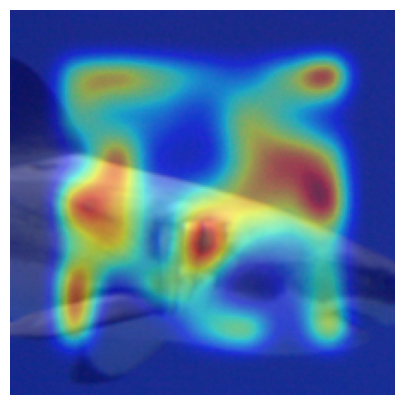

In [346]:
fig, ax = plt.subplots(figsize=(5, 5))

pad = (1,)*2
# no rellenar con ceros

nobs_cam_pad = np.pad(nobs_cam, pad_width=(pad, pad), mode='constant', constant_values=0)# no rellenar con ceros 
overlay = to_pil_image(nobs_cam_pad, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay = (cmap(np.asarray(overlay) ** 2)[:, :, :3])

input_tensor = images[index].unsqueeze(0)
input_numpy = input_tensor.detach().cpu().numpy()
input_numpy = input_numpy - input_numpy.min()
input_numpy = input_numpy / input_numpy.max()
input_numpy = np.transpose(input_numpy.squeeze(), (1, 2, 0))


ax.imshow(input_numpy)
ax.imshow(overlay, alpha=0.5)
ax.axis('off')
plt.show()

In [347]:
input_numpy.shape

(224, 224, 3)

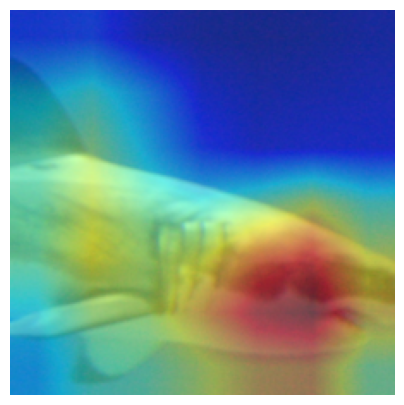

In [348]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

target_layers = [model.layer4[-1]]
input_tensor = images[index].unsqueeze(0)
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(real_labels[torch.argmax(y[index])])]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Normalizar el tensor a [0, 1] y convertirlo a un array de NumPy
input_numpy = input_tensor.detach().cpu().numpy()
input_numpy = input_numpy - input_numpy.min()
input_numpy = input_numpy / input_numpy.max()

# Ajustar la forma de la máscara para que coincida con la de la imagen
grayscale_cam = grayscale_cam.squeeze()

# Transponer input_numpy para que tenga la forma (3,224,224)
input_numpy = np.transpose(input_numpy.squeeze(), (1, 2, 0))

cam_image = show_cam_on_image(input_numpy, grayscale_cam, use_rgb=True)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.imshow(images[index].permute(1, 2, 0))
ax.imshow(cam_image)
ax.axis('off')
plt.show()


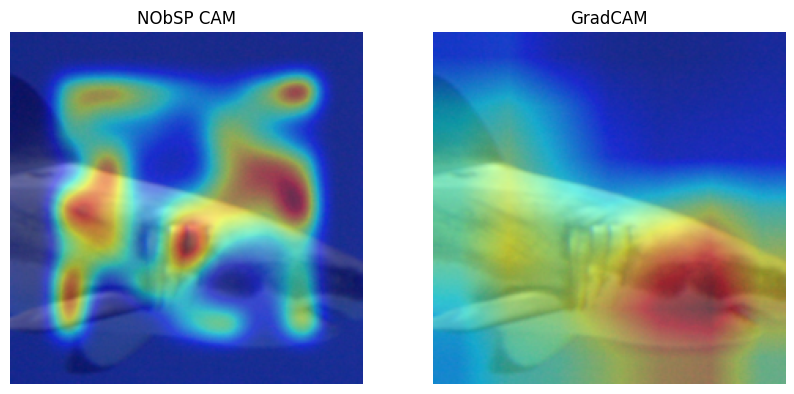

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(input_numpy)
ax[0].imshow(overlay, alpha=0.5)
ax[0].set_title("NObSP CAM")
ax[0].axis('off')

ax[1].imshow(cam_image)
ax[1].axis('off')
ax[1].set_title("GradCAM")


plt.show()